In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns


import sys
import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from collections import defaultdict
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

In [3]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [4]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/games',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/games/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
games_df = pd.concat(df_list, ignore_index=True)


In [5]:
# drop values
games_df = games_df.dropna()

# drop non english reviews
games_df['lang'] = games_df['review'].apply(tf.detect_language)

games_df = games_df.query('lang == "en"')


In [6]:
games_df['review_tokens'] = games_df['review'].apply(tf.clean_tokenize)
games_df['review_title_tokens'] = games_df['review_title'].apply(tf.clean_tokenize)

In [7]:
games_df.groupby(['rating'])['review'].count()

rating
1.0    357
2.0     68
3.0     81
4.0    108
5.0    676
Name: review, dtype: int64

In [8]:
games_df['sentiment'] = 0
games_df.loc[games_df['rating']>3, 'sentiment'] = 1
games_df.loc[games_df['rating']<=3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

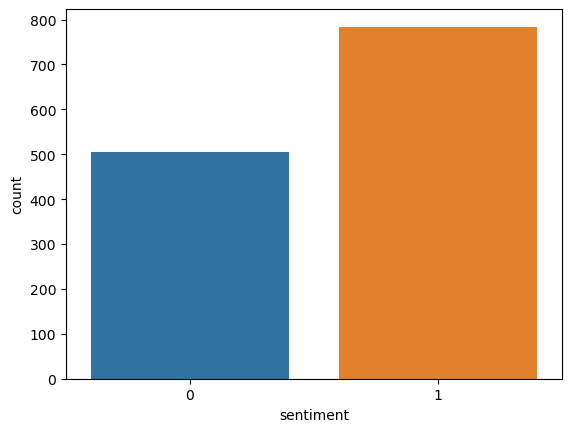

In [9]:
sns.countplot(x=games_df['sentiment'])

## Split Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(games_df['review'], games_df['sentiment'], test_size=0.20, random_state=10, stratify=games_df['sentiment'])

In [11]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  1032
Size of Test Data  258
Distribution of classes in Training Data :
Positive Sentiment  60.75581395348837
Negative Sentiment  39.24418604651162
Distribution of classes in Testing Data :
Positive Sentiment  60.85271317829457
Negative Sentiment  39.14728682170542


## Vectorize Data

In [12]:
count = CountVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_count_vectors = count.fit_transform(games_df['review'])

idf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_tfidf_vectors = idf.fit_transform(games_df['review'])

In [13]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Train Sentiment Model

In [14]:
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
y_pred = svc_model.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('ROC-AUC Score - ', roc_auc_score(y_test, y_pred))

Accuracy Score -  0.8333333333333334
ROC-AUC Score -  0.8171470013243363


## Sample Predictions

In [16]:
sample_reviews = games_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
1144,Not happy at all - I bought for my grandson an...,0
1252,I've been a fan since the first one and have a...,1
76,"The game is an amazing, open world adventure t...",1
1298,They should have just left the franchise dead....,0
142,these games don’t have difficulty setting beca...,1


## Pickle Models

In [17]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

## Topic Modeling

In [18]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [54]:
def topic_to_category(matrix, df):
    topic_to_category = defaultdict(list)
    for idx, row in enumerate(matrix) :
        topic = np.where(row == np.amax(row))[0]
        category = df["sentiment"].iloc[idx]
        sentiment = []
        if category == 1:
            sentiment.append("Positive")
        else:
            sentiment.append("Negative")
        topic_to_category[topic[0]].append(sentiment)  
    return topic_to_category

### NMF

In [19]:
nmf_text_model = NMF(n_components=2, random_state=33)
nmf_text_matrix = nmf_text_model.fit_transform(X_tfidf_vectors)
c_text_matrix = nmf_text_model.components_

In [20]:
display_topics(nmf_text_model, idf.get_feature_names_out(), 12)


Topic 00
  game (4.34)
  great (1.70)
  love (1.18)
  good (1.13)
  fun (1.13)
  like (1.08)
  halo (1.07)
  play (1.04)
  games (0.83)
  graphics (0.76)
  story (0.69)
  best (0.68)

Topic 01
  xbox (8.28)
  one (4.33)
  code (3.47)
  work (2.95)
  series (1.81)
  get (1.61)
  version (1.58)
  digital (1.53)
  compatible (1.46)
  play (1.43)
  disc (1.34)
  money (1.07)


In [59]:
nmf_topic_to_category = topic_to_category(nmf_text_matrix, games_df)
nmf_topic_to_category

defaultdict(list,
            {0: [['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],

### SVD

In [21]:
svd_text_model = TruncatedSVD(n_components=2, random_state=33)
svd_text_matrix = svd_text_model.fit_transform(X_tfidf_vectors)
csvd_text_matrix = svd_text_model.components_

In [22]:
display_topics(svd_text_model, idf.get_feature_names_out(), 12)


Topic 00
  game (3.72)
  great (1.39)
  play (1.12)
  xbox (1.06)
  one (0.95)
  love (0.95)
  like (0.93)
  good (0.92)
  fun (0.91)
  halo (0.89)
  games (0.78)
  get (0.76)

Topic 01
  xbox (13.10)
  one (7.01)
  code (5.63)
  work (4.39)
  series (2.84)
  version (2.54)
  digital (2.47)
  compatible (2.39)
  get (2.35)
  disc (2.08)
  buy (1.75)
  money (1.73)


In [58]:
svd_topic_to_category = topic_to_category(svd_text_matrix, games_df)
svd_topic_to_category

defaultdict(list,
            {0: [['Positive'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],

### LDA

In [23]:
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=33)
lda_text_matrix = lda_text_model.fit_transform(X_count_vectors)
clda_text_matrix = lda_text_model.components_

In [24]:
display_topics(lda_text_model, count.get_feature_names_out(), 12)


Topic 00
  game (6.79)
  xbox (2.28)
  one (1.83)
  get (1.67)
  play (1.58)
  code (0.95)
  time (0.85)
  buy (0.84)
  work (0.81)
  bought (0.79)
  good (0.79)
  would (0.78)

Topic 01
  game (6.10)
  halo (1.86)
  like (1.70)
  games (1.14)
  story (1.14)
  great (1.11)
  fun (1.07)
  world (1.06)
  play (1.05)
  much (0.83)
  really (0.77)
  new (0.77)


In [57]:
lda_topic_to_category = topic_to_category(lda_text_matrix, games_df)
lda_topic_to_category

defaultdict(list,
            {0: [['Positive'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Negative'],
              ['Positive'],
              ['Negative'],
              ['Negative'],

In [32]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, X_count_vectors, count, sort_topics=False)

In [33]:
pyLDAvis.display(lda_display)